In [1]:
from __future__ import unicode_literals,print_function,division
from io import open
import unicodedata
import string
import re
import random
import os
import librosa
import pickle
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
import math
import librosa.display
import numpy as np

print(torch.__version__)
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

1.5.0
cuda:0


In [7]:
'''
Summary:
    将音乐转换为note
Parameters:
    data - libsora读取到的y
    rate - libsora读取到的rate
Return:
    Note - note列表
'''
def music2note(data,rate):
    #转置 降噪
    data=np.transpose(data)
    data=data/data.max()
    data[data<0.75]=0

    #单位频率
    unit_rate=rate/(data.shape[1]-1)
    Note=[]
    
    for i in data:
        arr=np.array(i)
        if i.max() != 0:
            index = (arr!=0).argmax(axis=0)
            Note.append(librosa.hz_to_note((index+1)*unit_rate))
    return  Note

'''
Summary:
    调用该函数返回最终的note列表

Return:
    data - note列表
'''
def ChangeMuisc2Note(filpath):
    y,rate=librosa.load(filpath,44100)
    #短时傅里叶
    fft=librosa.stft(y,n_fft=1024*2)
    #转换为分贝值
    D=librosa.amplitude_to_db(abs(fft),ref=np.max)
    #数据>0
    D=D+80
    
    data=music2note(D,rate/2)
    return data



def getData():
    path='wavDatasets//'
    listdir=os.listdir(path)
    data={}
    for x in listdir:
        try:
            y = ChangeMuisc2Note('wavDatasets//'+x)
            y = one_hot(y)
            data[x[0:-4]]=y
        except:
            ''''''
    return data



def getLabel():
    with open ('wavDatasets//music_dic.pkl','rb') as df:#注意此处是rb
        #此处使用的是load(目标文件)
        music_dic=pickle.load(df)
    label={}
    for x in music_dic.keys():
        y=music_dic[x]
        label[x]=one_hot(y)
    return label

note_label_list = ['<S>','<E>','C5', 'C5#', 'C6', 'C4', 'C6#', 'C4#', 'D5', 'D5#', 'D6', 
            'D4', 'D6#', 'D4#', 'E5', 'E6', 'E4', 'F5', 'F5#', 'F6', 'F4', 'F6#',
            'F4#', 'G5', 'G5#', 'G6', 'G4', 'G6#', 'G4#', 'A5', 'A5#', 'A6', 'A4', 
            'A6#', 'A4#', 'B5', 'B6', 'B4', 'C5-', 'C5--', 'C5---', 'C5.', '<C5>',
            '<<C5>>', 'C5#-', 'C5#--', 'C5#---', 'C5#.', '<C5#>', '<<C5#>>', 'C6-',
            'C6--', 'C6---', 'C6.', '<C6>', '<<C6>>', 'C4-', 'C4--', 'C4---', 'C4.', 
            '<C4>', '<<C4>>', 'C6#-', 'C6#--', 'C6#---', 'C6#.', '<C6#>', '<<C6#>>',
            'C4#-', 'C4#--', 'C4#---', 'C4#.', '<C4#>', '<<C4#>>', 'D5-', 'D5--',
            'D5---', 'D5.', '<D5>', '<<D5>>', 'D5#-', 'D5#--', 'D5#---', 'D5#.', 
            '<D5#>', '<<D5#>>', 'D6-', 'D6--', 'D6---', 'D6.', '<D6>', '<<D6>>', 
            'D4-', 'D4--', 'D4---', 'D4.', '<D4>', '<<D4>>', 'D6#-', 'D6#--', 'D6#---',
            'D6#.', '<D6#>', '<<D6#>>', 'D4#-', 'D4#--', 'D4#---', 'D4#.', '<D4#>', 
            '<<D4#>>', 'E5-', 'E5--', 'E5---', 'E5.', '<E5>', '<<E5>>', 'E6-', 'E6--',
            'E6---', 'E6.', '<E6>', '<<E6>>', 'E4-', 'E4--', 'E4---', 'E4.', '<E4>', 
            '<<E4>>', 'F5-', 'F5--', 'F5---', 'F5.', '<F5>', '<<F5>>', 'F5#-', 'F5#--',
            'F5#---', 'F5#.', '<F5#>', '<<F5#>>', 'F6-', 'F6--', 'F6---', 'F6.',
            '<F6>', '<<F6>>', 'F4-', 'F4--', 'F4---', 'F4.', '<F4>', '<<F4>>', 
            'F6#-', 'F6#--', 'F6#---', 'F6#.', '<F6#>', '<<F6#>>', 'F4#-', 'F4#--',
            'F4#---', 'F4#.', '<F4#>', '<<F4#>>', 'G5-', 'G5--', 'G5---', 'G5.',
            '<G5>', '<<G5>>', 'G5#-', 'G5#--', 'G5#---', 'G5#.', '<G5#>', '<<G5#>>', 
            'G6-', 'G6--', 'G6---', 'G6.', '<G6>', '<<G6>>', 'G4-', 'G4--', 'G4---', 
            'G4.', '<G4>', '<<G4>>', 'G6#-', 'G6#--', 'G6#---', 'G6#.', '<G6#>', 
            '<<G6#>>', 'G4#-', 'G4#--', 'G4#---', 'G4#.', '<G4#>', '<<G4#>>', 'A5-',
            'A5--', 'A5---', 'A5.', '<A5>', '<<A5>>', 'A5#-', 'A5#--', 'A5#---', 'A5#.',
            '<A5#>', '<<A5#>>', 'A6-', 'A6--', 'A6---', 'A6.', '<A6>', '<<A6>>', 'A4-', 'A4--',
            'A4---', 'A4.', '<A4>', '<<A4>>', 'A6#-', 'A6#--', 'A6#---', 'A6#.', '<A6#>', 
            '<<A6#>>', 'A4#-', 'A4#--', 'A4#---', 'A4#.', '<A4#>', '<<A4#>>', 'B5-',
            'B5--', 'B5---', 'B5.', '<B5>', '<<B5>>', 'B6-', 'B6--', 'B6---', 'B6.',
            '<B6>', '<<B6>>', 'B4-', 'B4--', 'B4---', 'B4.', '<B4>', '<<B4>>','other']

#得到note和num字典
def getDict():
    note_dic = {}
    for x in range(len(note_label_list)):
        note_dic[note_label_list[x]] = x
    num_dic=dict(zip(note_dic.values(),note_dic.keys()))

    return note_dic,num_dic

note_dic,num_dic = getDict()

def one_hot(y):
    note=[]
    note.append(note_dic['<S>'])
    for x in y:
        try:
            note.append(note_dic[x])
        except:
            note.append(note_dic['other'])
    note.append(note_dic['<E>'])
    return note

#会调用前面的函数，最后返回训练集的数据
#形状为（x_train,y_train)，x_train是训练集音频数据，y_train是训练集数据标签
#数据类型均为torch.longtensor
def getPair():
    x=getData()
    #print(x)
    y=getLabel()
    data=[]
    label=[]
    for key in x.keys():
        a=x[key]
        a=list(a)
        #print(a)
        # 数据放到cuda上
        a=torch.Tensor(a).view(len(a),1).long().cuda()
        b=torch.Tensor(y[key]).view(len(y[key]),1).long().cuda()
        data.append(a)
        label.append(b)
    return data,label

In [ ]:
#获取数据和字典
x_train, y_train = getPair()
MAX_LENGTH = max([i.shape[0] for i in x_train])
S_token=0#代表句子的开始
E_token=1#代表句子的结束

with open('x_train.pkl','rb') as x_file:
    pickle.dump(x_train,x_file)
    
with open('y_train.pkl','rb') as y_file:
    pickle.dump(y_train,x_file)

In [6]:
len(x_train)

0

In [26]:
#不要动它
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#不要动它
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length=max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat([embedded[0], hidden[0]], 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat([embedded[0], attn_applied[0]], 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#不要动它
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion,maxlen=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(maxlen, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([[S_token]], device=device)

    decoder_hidden = encoder_hidden
    teacher_forcing_ratio=0.5
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the targer as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing


    else:
        # Without teaching forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == E_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#不要动它
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#不要动它
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [39]:
#epochs是训练迭代次数
def trainIters(encoder, decoder, n_iters, print_every=1, plot_every=1, learning_rate=0.01,epochs=10):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()
    for epoch in range(epochs):
        print('epoch:',epoch)
        for iter in range(1, n_iters + 1):
            #print('iter:',iter)
            input_tensor = x_train[iter-1]
            target_tensor = y_train[iter-1]
            #print('input_tensor:',input_tensor.size())
            #print('target_tensor:',target_tensor.size())

            loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

            print_loss_total += loss
            plot_loss_total += loss
            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                
            #if iter % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                     iter, iter / n_iters * 100, print_loss_avg))

            
    showPlot(plot_losses)
    return plot_losses

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#不要动它
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

#不要动它
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = sentence
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[S_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            # print(topi.item())
            if topi.item() == E_token:
                # print('<E>')
                decoded_words.append('<E>')
                break
            else:
                # print(di,num_dic[topi.item()])
                decoded_words.append(num_dic[topi.item()])


            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#x_test是测试音频数据
#y_test是测试数据标签
#n是测试数据的数量
def evaluateRandomly(encoder, decoder, x_test,y_test=None,n=1):
    for i in range(n):
        print('>', x_test[i].size())
        print('=', y_test[i].size())
        y_word = []
        for each in y_test[i]:
            #print(each.item())
            y_word.append(num_dic[each.item()])
        
        output_words, attentions = evaluate(encoder, decoder, x_test[i])
        output_sentence = ' '.join(output_words)
        print('原来结果', ' '.join(y_word))
        print('预测结果', output_sentence)
        print('')
        return output_words

In [40]:
hidden_size = 256
dic_size = len(note_label_list)
# 第一个参数是字典大小
encoder1 = EncoderRNN(dic_size, hidden_size).to(device)
#第二个参数是字典大小
attn_decoder1 = AttnDecoderRNN(hidden_size, dic_size, dropout_p=0.1).to(device)

In [41]:
encoder1

EncoderRNN(
  (embedding): Embedding(255, 256)
  (gru): GRU(256, 256)
)

In [42]:
attn_decoder1

AttnDecoderRNN(
  (embedding): Embedding(255, 256)
  (attn): Linear(in_features=512, out_features=2500, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=255, bias=True)
)

epoch: 0
7m 5s (- 0m 0s) (350 100%) 1369.7623
epoch: 1
14m 16s (- 0m 0s) (350 100%) 1298.7485
epoch: 2
21m 25s (- 0m 0s) (350 100%) 1265.4764
epoch: 3
28m 38s (- 0m 0s) (350 100%) 1240.6402
epoch: 4
35m 59s (- 0m 0s) (350 100%) 1292.0179
epoch: 5
43m 8s (- 0m 0s) (350 100%) 1250.1664
epoch: 6
50m 10s (- 0m 0s) (350 100%) 1247.3618
epoch: 7
57m 8s (- 0m 0s) (350 100%) 1222.2701
epoch: 8
64m 9s (- 0m 0s) (350 100%) 1199.9918
epoch: 9
71m 19s (- 0m 0s) (350 100%) 1190.2647
epoch: 10
78m 41s (- 0m 0s) (350 100%) 1177.4046
epoch: 11
85m 57s (- 0m 0s) (350 100%) 1183.4010
epoch: 12
93m 10s (- 0m 0s) (350 100%) 1151.3781
epoch: 13
100m 25s (- 0m 0s) (350 100%) 1151.5219
epoch: 14
107m 25s (- 0m 0s) (350 100%) 1120.7913
epoch: 15
114m 24s (- 0m 0s) (350 100%) 1092.0958
epoch: 16
121m 22s (- 0m 0s) (350 100%) 1099.1053
epoch: 17
128m 22s (- 0m 0s) (350 100%) 1108.0370
epoch: 18
135m 40s (- 0m 0s) (350 100%) 1047.6623
epoch: 19
142m 55s (- 0m 0s) (350 100%) 1054.7013


<Figure size 432x288 with 0 Axes>

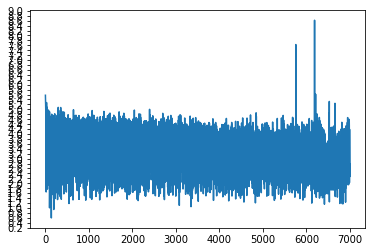

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [43]:
#n_iters是训练集数据的个数，可以小于，但不能大于
#epochs是可调参数，代表训练次数
plot_losses = trainIters(encoder1, attn_decoder1, n_iters=len(x_train),epochs=20)

torch.save(encoder1,'ecnoder1.pkl')
torch.save(attn_decoder1,'attn_decoder1.pkl')

In [44]:

#x_train和y_train是测试数据。
#n代表测试多少个测试数据
res=evaluateRandomly(encoder1, attn_decoder1,x_train,y_train,n=1)

print(len(x_train))
print(x_train[0].size())

> torch.Size([1036, 1])
= torch.Size([15, 1])
原来结果 <S> C5 E5 A5# C5--- F6 F4 F5 E5 E5 <D5> C5. <D4> <<E4>> <E>
预测结果 <S> C5 E5 C5 F6 C5 C5 C5--- F6 C5 C5 C5 C5--- F6 C5 C5 C5--- C5. C5 E5 E5 B5 <E>

350
torch.Size([1036, 1])


In [45]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ".ipynb_checkpoints/\350\277\220\350\241\214\347\245\236\347\273\217\347\275\221\347\273\234-checkpoint.ipynb"
	modified:   attn_decoder1.pkl
	modified:   ecnoder1.pkl
	modified:   "\346\225\260\346\215\256\351\233\206\345\210\266\344\275\234/midi2wav.jar"
	modified:   "\346\225\260\346\215\256\351\233\206\345\210\266\344\275\234/\345\210\266\344\275\234\346\225\260\346\215\256\351\233\206.ipynb"
	modified:   "\350\277\220\350\241\214\347\245\236\347\273\217\347\275\221\347\273\234.ipynb"

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	".ipynb_checkpoints/\345\256\211\350\243\205\347\216\257\345\242\203-checkpoint.html"
	".ipynb_checkpoints/\345\256\211\350\243\205\347\216\257\345\242\203-checkpoint.ipynb"

In [ ]:
rmtree('wavDatasets')

In [ ]:
y, sr = librosa.load('wavDatasets/2020-05-26_17_15_16_0.wav')
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')

In [52]:

import wave
f = wave.open("wavDatasets/2020-05-26_17_15_16_0.wav", "rb")
# 读取格式信息
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
# 读取波形数据
str_data = f.readframes(nframes)
f.close()
#将波形数据转换为数组
wave_data = np.fromstring(str_data, dtype=np.short)
wave_data.shape = -1, 2
wave_data = wave_data.T
time = np.arange(0, nframes) * (1.0 / framerate)
# 绘制波形

plt.plot(time, wave_data[0])

plt.plot(time, wave_data[1], c="g")

Error: unknown format: 3